In [19]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

import planetary_computer as pc
import rioxarray as rioxr

import gc # garbage collector

## Import train/test sets

In [2]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','train_set.csv')).loc[:,'iceplant'] 

# X_test = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','test_set.csv')).loc[:,'r':'avg_lidar']
# y_test = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','test_set.csv')).loc[:,'iceplant']

In [3]:
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
0,43,51,78,89,0.348485,2012,5,126,2,10,0,10,3.000000
1,65,59,84,79,0.097222,2012,5,126,0,6,0,6,1.000000
2,81,86,93,132,0.239437,2012,5,126,11,14,6,8,9.222222


In [4]:
mpe.iceplant_proportions(np.array(y_train))

no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0         247696       70.95
1         101425       29.05



In [5]:
# mpe.iceplant_proportions(np.array(y_test))

## Train model

In [6]:
from dask_ml.wrappers import ParallelPostFit

In [7]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  41.42403697967529


In [8]:
# predictions = rfc.predict(X_test)
# mpe.print_threshold_metrics(y_test, predictions)

## Feature importance

In [9]:
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

In [10]:
# forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 
#                                                                'year', 'month', 'day_in_year',
#                                                               'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])


In [11]:
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

## Open NAIP scene and clip LIDAR

In [20]:
# NAIP scene over Conception Point
itemid = 'ca_m_3412037_nw_10_060_20200607'
href = pc.sign(ipf.get_item_from_id(itemid).assets["image"].href)

# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))

In [21]:
import lidar_sampling_functions_Copy1 as lsf

In [14]:
fp = os.path.join(os.getcwd(),
                  'model_with_lidar',
                  'SantaBarbaraCounty_lidar_2020.tif')
lidar_reader = rasterio.open(fp)
lsf.save_min_max_rasters(lidar_reader, os.getcwd()+'/temp',2020)
lsf.save_avg_rasters(lidar_reader, os.getcwd()+'/temp',2020)

In [15]:
def open_and_match(fp, reproject_to):
    rast = rioxr.open_rasterio(fp)
    rast_match = rast.rio.reproject_match(reproject_to)
    return rast_match.squeeze()

In [22]:
lidar_match = open_and_match(fp, naip_scene)

In [26]:
fp = os.path.join(os.getcwd(),'temp','lidar_mins_2020.tif')
mins_match = open_and_match(fp, naip_scene)

In [27]:
fp = os.path.join(os.getcwd(),'temp','lidar_maxs_2020.tif')
maxs_match = open_and_match(fp, naip_scene)

In [30]:
fp = os.path.join(os.getcwd(),'temp','lidar_avgs_2020.tif')
avg_match = open_and_match(fp, naip_scene)

In [31]:
# select pixel with vegetation
veg = ipf.features_over_aoi(ipf.get_item_from_id(itemid), 
                           naip_scene.to_numpy(), 
                           thresh=0.05)
veg

,r,g,b,nir,ndvi,year,month,day_in_year
580,92,91,82,102,0.051546,2020,6,159
588,76,75,71,85,0.055901,2020,6,159
591,96,95,82,107,0.054187,2020,6,159
592,93,101,80,122,0.134884,2020,6,159
593,97,96,87,110,0.062802,2020,6,159
...,...,...,...,...,...,...,...,...
119283715,45,50,67,50,0.052632,2020,6,159
119473061,43,49,71,60,0.165049,2020,6,159
119473062,36,45,62,55,0.208791,2020,6,159
119483582,47,58,73,63,0.145455,2020,6,159


In [35]:
df_lidar = pd.DataFrame()
df_lidar['lidar'] = lidar_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['max_lidar'] = maxs_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_lidar'] = mins_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_max_diff'] = df_lidar.max_lidar - df_lidar.min_lidar
df_lidar['avg_lidar'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

In [36]:
df_lidar_veg = df_lidar.iloc[veg.index]
df_lidar_veg

,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
580,1,3,0,3,1.555556
588,1,3,0,3,1.555556
591,2,3,1,2,1.888889
592,2,3,1,2,1.888889
593,2,3,1,2,1.888889
...,...,...,...,...,...
119283715,-9999,241,241,0,0.000000
119473061,-9999,241,241,0,0.000000
119473062,-9999,241,241,0,0.000000
119483582,-9999,241,241,0,0.000000


In [37]:
del df_lidar
gc.collect()

In [40]:

# ['r', 'g', 'b', 'nir', 'ndvi', 
#  'year', 'month', 'day_in_year',
#  'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])

scene_features = pd.concat([veg,df_lidar_veg],axis=1)
scene_features.head(4)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
580,92,91,82,102,0.051546,2020,6,159,1,3,0,3,1.555556
588,76,75,71,85,0.055901,2020,6,159,1,3,0,3,1.555556
591,96,95,82,107,0.054187,2020,6,159,2,3,1,2,1.888889
592,93,101,80,122,0.134884,2020,6,159,2,3,1,2,1.888889


In [41]:
del veg
del df_lidar_veg
gc.collect()

777

In [42]:
predictions = rfc.predict(scene_features.to_numpy())

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [44]:
# attach predictions to index of analyzed pixels
is_iceplant = pd.DataFrame(predictions, columns=['is_iceplant'], index=scene_features.index)

# select pixels classified as iceplant
is_iceplant = is_iceplant[is_iceplant.is_iceplant == 1]

In [47]:
preds_image = ipf.indices_backto_image(naip_scene.shape[1], naip_scene.shape[2], is_iceplant.index)

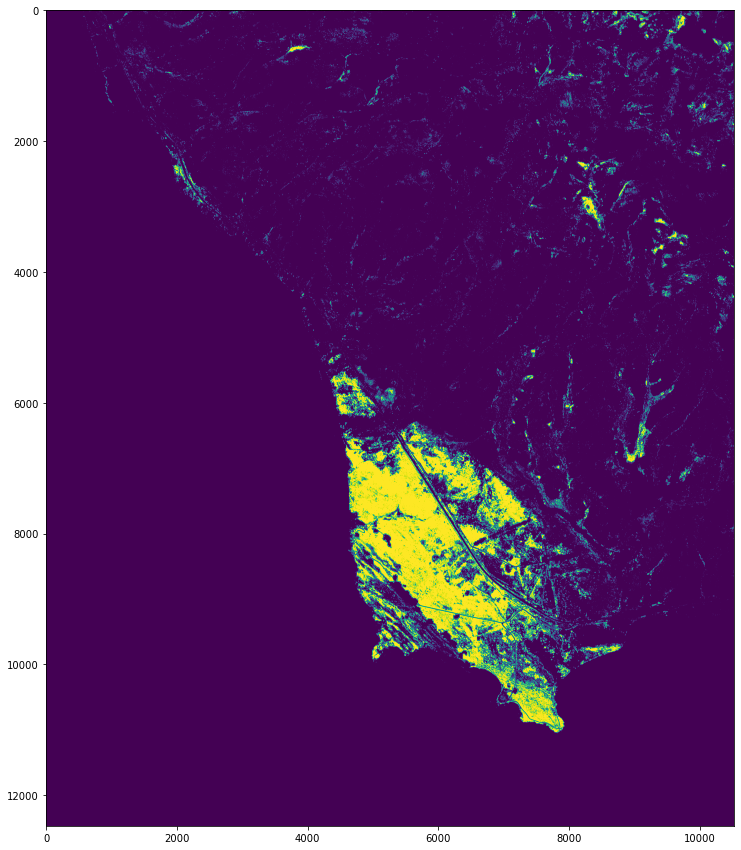

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(preds_image)
plt.show()